# 08-Difference-in-Differences


## Panel Data


In [1]:
from toolz import *

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

In [2]:
import pandas as pd
import numpy as np

mkt_data = (pd.read_csv("./data/short_offline_mkt_south.csv")
            .astype({"date":"datetime64[ns]"}))

mkt_data.head()

,date,city,region,treated,tau,downloads,post
0,2021-05-01,5,S,0,0.0,51.0,0
1,2021-05-02,5,S,0,0.0,51.0,0
2,2021-05-03,5,S,0,0.0,51.0,0
3,2021-05-04,5,S,0,0.0,50.0,0
4,2021-05-05,5,S,0,0.0,49.0,0


In [3]:
(mkt_data
 .assign(w = lambda d: d["treated"]*d["post"])
 .groupby(["w"])
 .agg({"date":[min, max]}))

date           
         min        max
w                      
0 2021-05-01 2021-06-01
1 2021-05-15 2021-06-01

## Canonical Difference-in-Differences


In [4]:
did_data = (mkt_data
            .groupby(["treated", "post"])
            .agg({"downloads":"mean", "date": "min"}))

did_data

downloads       date
treated post                      
0       0     50.335034 2021-05-01
        1     50.556878 2021-05-15
1       0     50.944444 2021-05-01
        1     51.858025 2021-05-15

In [5]:
y0_est = (did_data.loc[1].loc[0, "downloads"] # treated baseline
          # control evolution
          + did_data.loc[0].diff().loc[1, "downloads"]) 

att = did_data.loc[1].loc[1, "downloads"] - y0_est
att

0.6917359536407233

In [6]:
mkt_data.query("post==1").query("treated==1")["tau"].mean()

0.7660316402518457

### Diff-in-Diff with Outcome Growth


In [7]:
pre = mkt_data.query("post==0").groupby("city")["downloads"].mean()
post = mkt_data.query("post==1").groupby("city")["downloads"].mean()

delta_y = ((post - pre)
           .rename("delta_y")
           .to_frame()
           # add the treatment dummy
           .join(mkt_data.groupby("city")["treated"].max()))

delta_y.tail()

,delta_y,treated
city,,
192,0.555556,0
193,0.166667,0
195,0.420635,0
196,0.119048,0
197,1.595238,1


In [8]:
(delta_y.query("treated==1")["delta_y"].mean() 
 - delta_y.query("treated==0")["delta_y"].mean())

0.6917359536407155

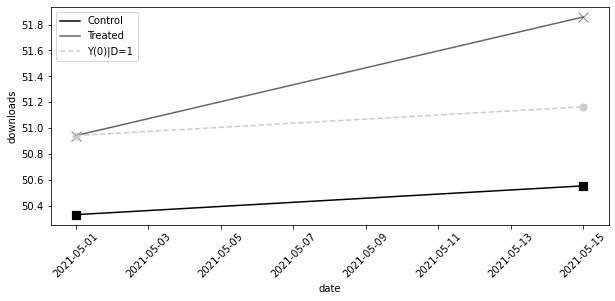

In [9]:
did_plt = did_data.reset_index()


plt.figure(figsize=(10,4))

sns.scatterplot(data=did_plt.query("treated==0"), x="date", y="downloads", s=100, color="C0", marker="s")
sns.lineplot(data=did_plt.query("treated==0"), x="date", y="downloads", label="Control", color="C0")

sns.scatterplot(data=did_plt.query("treated==1"), x="date", y="downloads", s=100, color="C1", marker="x")
sns.lineplot(data=did_plt.query("treated==1"), x="date", y="downloads", label="Treated", color="C1",)

plt.plot(did_data.loc[1, "date"], [did_data.loc[1, "downloads"][0], y0_est], color="C2", linestyle="dashed", label="Y(0)|D=1")
plt.scatter(did_data.loc[1, "date"], [did_data.loc[1, "downloads"][0], y0_est], color="C2", s=50)

plt.xticks(rotation = 45);
plt.legend()


### Diff-in-Diff with OLS


In [10]:
did_data = (mkt_data
            .groupby(["city", "post"])
            .agg({"downloads":"mean", "date": "min", "treated": "max"})
            .reset_index())

did_data.head()

,city,post,downloads,date,treated
0,5,0,50.642857,2021-05-01,0
1,5,1,50.166667,2021-05-15,0
2,15,0,49.142857,2021-05-01,0
3,15,1,49.166667,2021-05-15,0
4,20,0,48.785714,2021-05-01,0


In [11]:
import statsmodels.formula.api as smf

smf.ols(
    'downloads ~ treated*post', data=did_data
).fit().params["treated:post"]

0.6917359536406904

### Diff-in-Diff with Fixed Effects


In [12]:
m = smf.ols('downloads ~ treated:post + C(city) + C(post)',
            data=did_data).fit()

m.params["treated:post"]

0.6917359536407091

### Multiple Time Periods


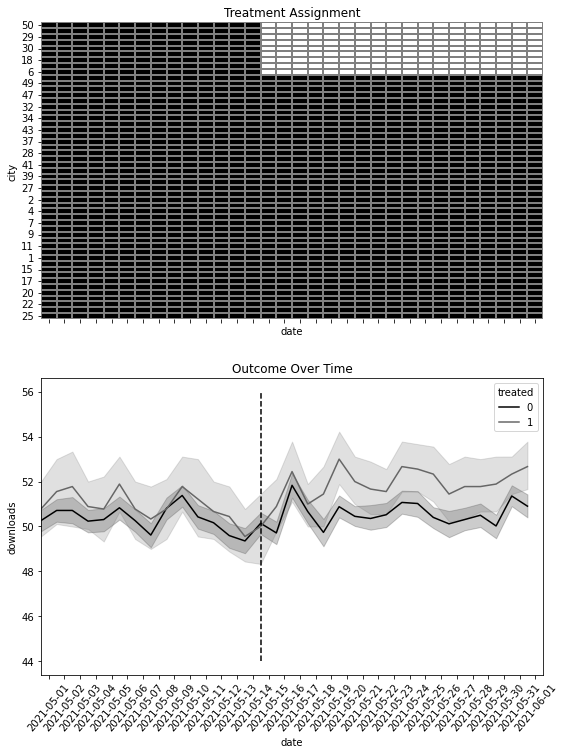

In [13]:
import matplotlib.ticker as plticker


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9, 12), sharex=True)

heat_plt = (mkt_data
            .assign(treated=lambda d: d.groupby("city")["treated"].transform(max))            
            .astype({"date":"str"})
            .assign(treated=mkt_data["treated"]*mkt_data["post"])
            .pivot("city", "date", "treated")
            .reset_index()
            .sort_values(max(mkt_data["date"].astype(str)), ascending=False)
            .reset_index()
            .drop(columns=["city"])
            .rename(columns={"index":"city"})
            .set_index("city"))


sns.heatmap(heat_plt, cmap="gray", linewidths=0.01, linecolor="0.5", ax=ax1, cbar=False)

ax1.set_title("Treatment Assignment")


sns.lineplot(data=mkt_data.astype({"date":"str"}),
             x="date", y="downloads", hue="treated", ax=ax2)

loc = plticker.MultipleLocator(base=2.0)
# ax2.xaxis.set_major_locator(loc)
ax2.vlines("2021-05-15", mkt_data["downloads"].min(), mkt_data["downloads"].max(), color="black", ls="dashed", label="Interv.")
ax2.set_title("Outcome Over Time")

plt.xticks(rotation = 50);

In [14]:
m = smf.ols('downloads ~ treated*post', data=mkt_data).fit()

m.params["treated:post"]

0.6917359536407226

In [15]:
m = smf.ols('downloads ~ treated:post + C(city) + C(date)',
            data=mkt_data).fit()

m.params["treated:post"]

0.6917359536407017

### Inference


In [16]:
m = smf.ols(
    'downloads ~ treated:post + C(city) + C(date)', data=mkt_data
).fit(cov_type='cluster', cov_kwds={'groups': mkt_data['city']})

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: 0.6917359536407017


0    0.296101
1    1.087370
Name: treated:post, dtype: float64

In [17]:
m = smf.ols('downloads ~ treated:post + C(city) + C(date)',
            data=mkt_data).fit()

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: 0.6917359536407017


0    0.478014
1    0.905457
Name: treated:post, dtype: float64

In [18]:
m = smf.ols(
    'downloads ~ treated:post + C(city) + C(date)', data=did_data
).fit(cov_type='cluster', cov_kwds={'groups': did_data['city']})

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: 0.6917359536407091


0    0.138188
1    1.245284
Name: treated:post, dtype: float64

In [19]:
def block_sample(df, unit_col):
    
    units = df[unit_col].unique()
    sample = np.random.choice(units, size=len(units), replace=True) 
    
    return (df
            .set_index(unit_col)
            .loc[sample]
            .reset_index(level=[unit_col]))

In [20]:
from joblib import Parallel, delayed

def block_bootstrap(data, est_fn, unit_col,
                    rounds=200, seed=123, pcts=[2.5, 97.5]):
    np.random.seed(seed)
    
    stats = Parallel(n_jobs=4)(
        delayed(est_fn)(block_sample(data, unit_col=unit_col))
        for _ in range(rounds))
    
    return np.percentile(stats, pcts)

In [21]:
def est_fn(df):
    m = smf.ols('downloads ~ treated:post + C(city) + C(date)',
                data=df).fit()
    return m.params["treated:post"]

block_bootstrap(mkt_data, est_fn, "city")

array([0.23162214, 1.14002646])

## Identification Assumptions


### Parallel Trends


Text(0, 0.5, 'Log(y)')

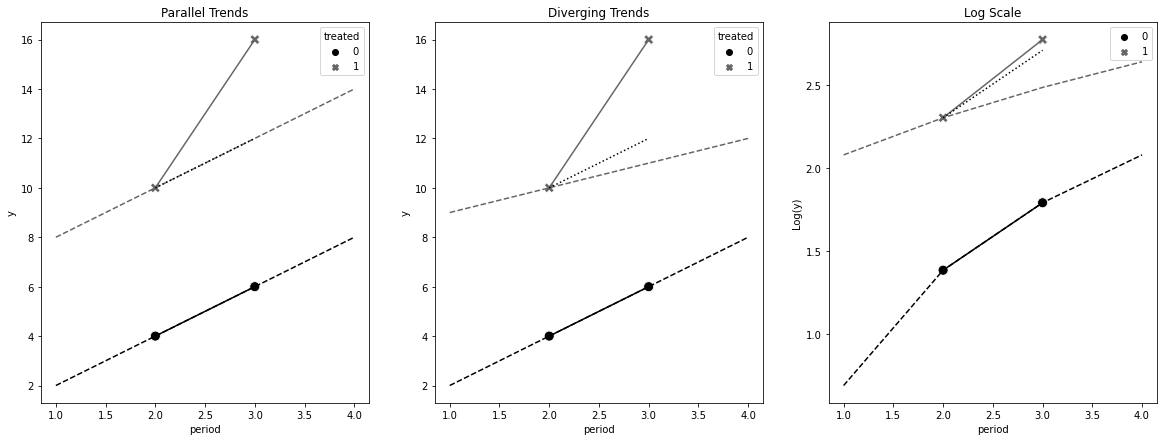

In [22]:
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(20,7))

obs_df = pd.DataFrame(dict(
    period = [2,3, 2,3],
    treated = [0,0, 1,1],
    y = [4,6, 10,16],
))

baseline = 10-4


plt_d1 = pd.DataFrame(dict(
    period = [1,2,3,4, 1,2,3,4],
    treated = [0,0,0,0, 1,1,1,1],
    y = [2,4,6,8, 8,10,12,14],
))

sns.lineplot(data=plt_d1, x="period", y="y", hue="treated", linestyle="dashed", legend=None, ax=ax1)
sns.lineplot(data=obs_df, x="period", y="y", hue="treated", legend=None, ax=ax1)
sns.lineplot(data=obs_df.assign(y=obs_df["y"] + baseline).query("treated==0"),
             x="period", y="y",  legend=None, ax=ax1, color="C0", linestyle="dotted")

sns.scatterplot(data=obs_df, x="period", y="y", hue="treated", style="treated", s=100, ax=ax1)
ax1.set_title("Parallel Trends")


plt_d2 = pd.DataFrame(dict(
    period = [1,2,3,4, 1,2,3,4],
    treated = [0,0,0,0, 1,1,1,1],
    y = [2,4,6,8, 9,10,11,12],
))

sns.lineplot(data=plt_d2, x="period", y="y", hue="treated", linestyle="dashed", legend=None, ax=ax2)
sns.lineplot(data=obs_df, x="period", y="y", hue="treated", legend=None, ax=ax2)
sns.scatterplot(data=obs_df, x="period", y="y", hue="treated", style="treated", s=100, ax=ax2)
sns.lineplot(data=obs_df.assign(y=obs_df["y"] + baseline).query("treated==0"),
             x="period", y="y",  legend=None, ax=ax2, color="C0", linestyle="dotted")

ax2.set_title("Diverging Trends")



non_lin = np.log
non_lin_obs = obs_df.assign(y=non_lin(obs_df["y"]))

plt_d3 = pd.DataFrame(dict(
    period = [1,2,3,4, 1,2,3,4],
    treated = [0,0,0,0, 1,1,1,1],
    y = non_lin([2,4,6,8, 8,10,12,14]),
))


sns.lineplot(data=plt_d3, x="period", y="y", hue="treated", linestyle="dashed", legend=None, ax=ax3)
sns.lineplot(data=non_lin_obs, x="period", y="y", hue="treated", legend=None, ax=ax3)
sns.scatterplot(data=non_lin_obs, x="period", y="y", hue="treated", style="treated", s=100, ax=ax3)
sns.lineplot(x=[2, 3], y=non_lin_obs.query("treated==1 & period==2")["y"].values - non_lin_obs.query("treated==0 & period==2")["y"].values + non_lin_obs.query("treated==0")["y"], color="C0", 
            linestyle="dotted")


ax3.set_title("Log Scale")
ax3.set_ylabel("Log(y)")


### No Anticipation Assumption and SUTVA 


### Strict Exogeneity


### No Time Varying Confounders


### No Feedback

### No Carryover and no Lagged Dependent Variable



## Effect Dynamics Over Time


In [23]:
def did_date(df, date):
    df_date = (df
               .query("date==@date | post==0")
               .query("date <= @date")
               .assign(post = lambda d: (d["date"]==date).astype(int)))
    
    m = smf.ols(
        'downloads ~ I(treated*post) + C(city) + C(date)', data=df_date
    ).fit(cov_type='cluster', cov_kwds={'groups': df_date['city']})
    
    att = m.params["I(treated * post)"]
    ci = m.conf_int().loc["I(treated * post)"]
    
    return pd.DataFrame({"att": att, "ci_low": ci[0], "ci_up": ci[1]},
                        index=[date])

In [24]:
post_dates = sorted(mkt_data["date"].unique())[1:]

atts = pd.concat([did_date(mkt_data, date)
                  for date in post_dates])

atts.head()

,att,ci_low,ci_up
2021-05-02,0.325397,-0.491741,1.142534
2021-05-03,0.384921,-0.388389,1.158231
2021-05-04,-0.156085,-1.247491,0.935321
2021-05-05,-0.299603,-0.949935,0.350729
2021-05-06,0.347619,0.013115,0.682123


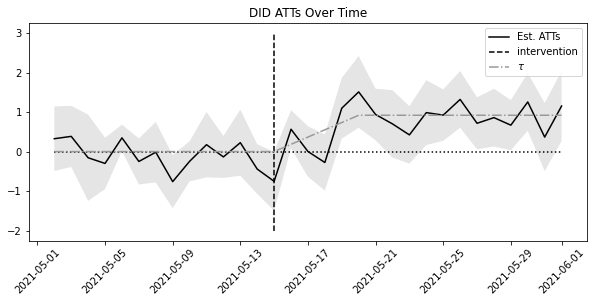

In [25]:

plt.figure(figsize=(10,4))
plt.plot(atts.index, atts["att"], label="Est. ATTs")

plt.fill_between(atts.index, atts["ci_low"], atts["ci_up"], alpha=0.1)

plt.vlines(pd.to_datetime("2021-05-15"), -2, 3, linestyle="dashed", label="intervention")
plt.hlines(0, atts.index.min(), atts.index.max(), linestyle="dotted")

plt.plot(atts.index, mkt_data.query("treated==1").groupby("date")[["tau"]].mean().values[1:], color="0.6", ls="-.", label="$\\tau$")

plt.xticks(rotation=45)
plt.title("DID ATTs Over Time")
plt.legend()


## Diff-in-Diff with Covariates


In [26]:
mkt_data_all = (pd.read_csv("./data/short_offline_mkt_all_regions.csv")
                .astype({"date":"datetime64[ns]"}))

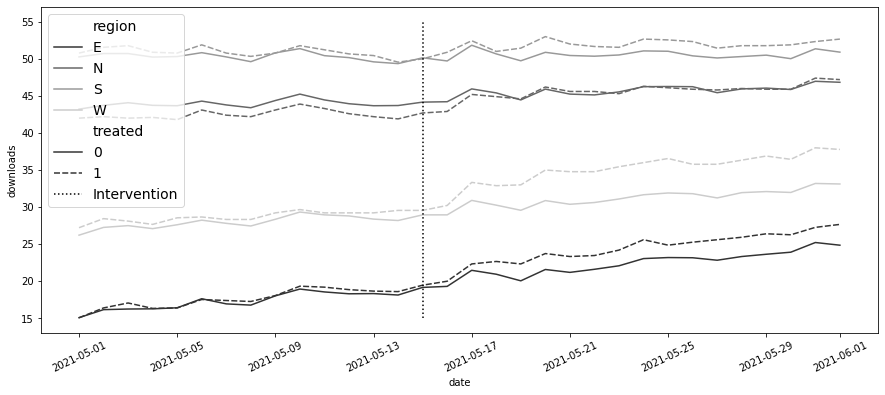

In [27]:
plt.figure(figsize=(15,6))
sns.lineplot(data=mkt_data_all.groupby(["date", "region", "treated"])[["downloads"]].mean().reset_index(),
             x="date", y="downloads", hue="region", style="treated", palette="gray")

plt.vlines(pd.to_datetime("2021-05-15"), 15, 55, ls="dotted", label="Intervention")
plt.legend(fontsize=14)

plt.xticks(rotation=25);

In [28]:
print("True ATT: ", mkt_data_all.query("treated*post==1")["tau"].mean())

m = smf.ols('downloads ~ treated:post + C(city) + C(date)',
            data=mkt_data_all).fit()

print("Estimated ATT:", m.params["treated:post"])

True ATT:  1.7208921056102682
Estimated ATT: 2.068391984256296


In [29]:
m = smf.ols('downloads ~ treated:post + C(city) + C(date) + C(region)',
            data=mkt_data_all).fit()
m.params["treated:post"] 

2.071153674125536

In [30]:
m_saturated = smf.ols('downloads ~ (post*treated)*C(region)',
                      data=mkt_data_all).fit()

atts = m_saturated.params[m_saturated.params.index.str.contains("post:treated")]
atts

post:treated                   1.676808
post:treated:C(region)[T.N]   -0.343667
post:treated:C(region)[T.S]   -0.985072
post:treated:C(region)[T.W]    1.369363
dtype: float64

In [31]:
reg_size = (mkt_data_all.groupby("region").size()
            /len(mkt_data_all["date"].unique()))

base = atts[0]

np.array([reg_size[0]*base]+
         [(att+base)*size
          for att, size in zip(atts[1:], reg_size[1:])]
        ).sum()/sum(reg_size)

1.6940400451471818

In [32]:
m = smf.ols('downloads ~ post*(treated + C(region))',
            data=mkt_data_all).fit()

m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.3522,0.101,172.218,0.000,17.155,17.550
C(region)[T.N],26.2770,0.137,191.739,0.000,26.008,26.546
C(region)[T.S],33.0815,0.135,245.772,0.000,32.818,33.345
C(region)[T.W],10.7118,0.135,79.581,0.000,10.448,10.976
post,4.9807,0.134,37.074,0.000,4.717,5.244
post:C(region)[T.N],-3.3458,0.183,-18.310,0.000,-3.704,-2.988
post:C(region)[T.S],-4.9334,0.179,-27.489,0.000,-5.285,-4.582
post:C(region)[T.W],-1.5408,0.179,-8.585,0.000,-1.893,-1.189
treated,0.0503,0.117,0.429,0.668,-0.179,0.280
post:treated,1.6811,0.156,10.758,0.000,1.375,1.987


## Doubly Robust Diff-in-Diff

### Propensity Score Model


In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
unit_df = (mkt_data_all
           # keep only the first date
           .astype({"date": str})
           .query(f"date=='{mkt_data_all['date'].astype(str).min()}'")
           .drop(columns=["date"])) # just to avoid confusion

ps_model = smf.logit("treated~C(region)", data=unit_df).fit(disp=0)

### Delta Outcome Model


In [35]:
delta_y = (
    mkt_data_all.query("post==1").groupby("city")["downloads"].mean()
    - mkt_data_all.query("post==0").groupby("city")["downloads"].mean()
)

In [36]:
df_delta_y = (unit_df
              .set_index("city")
              .join(delta_y.rename("delta_y")))

outcome_model = smf.ols("delta_y ~ C(region)", data=df_delta_y).fit()

### All Together Now


In [37]:
df_dr = (df_delta_y
         .assign(y_hat = lambda d: outcome_model.predict(d))
         .assign(ps = lambda d: ps_model.predict(d)))

df_dr.head()

,region,treated,tau,downloads,post,delta_y,y_hat,ps
city,,,,,,,,
1,W,0,0.0,27.0,0,3.087302,3.736539,0.176471
2,N,0,0.0,40.0,0,1.436508,1.992570,0.212766
3,W,0,0.0,30.0,0,2.761905,3.736539,0.176471
4,W,0,0.0,26.0,0,3.396825,3.736539,0.176471
5,S,0,0.0,51.0,0,-0.476190,0.343915,0.176471


In [38]:
tr = df_dr.query("treated==1")
co = df_dr.query("treated==0")

dy1_treat = (tr["delta_y"] - tr["y_hat"]).mean()

w_cont = co["ps"]/(1-co["ps"])
dy0_treat = np.average(co["delta_y"] - co["y_hat"], weights=w_cont)

print("ATT:", dy1_treat - dy0_treat)

ATT: 1.6773180394442853


## Staggered Adoption


In [39]:
mkt_data_cohorts = (pd.read_csv("./data/offline_mkt_staggered.csv")
                    .astype({
                        "date":"datetime64[ns]",
                        "cohort":"datetime64[ns]"}))

mkt_data_cohorts.head()

,date,city,region,cohort,treated,tau,downloads,post
0,2021-05-01,1,W,2021-06-20,1,0.0,27.0,0
1,2021-05-02,1,W,2021-06-20,1,0.0,28.0,0
2,2021-05-03,1,W,2021-06-20,1,0.0,28.0,0
3,2021-05-04,1,W,2021-06-20,1,0.0,26.0,0
4,2021-05-05,1,W,2021-06-20,1,0.0,28.0,0


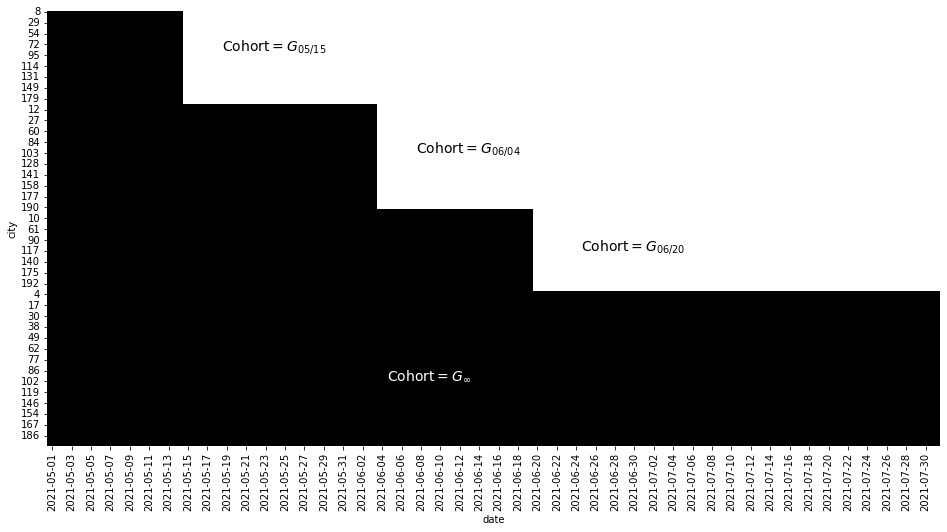

In [40]:
plt_data = (mkt_data_cohorts
            .astype({"date":"str"})
            .assign(treated_post = lambda d: d["treated"]*(d["date"]>=d["cohort"]))
            .pivot("city", "date", "treated_post")
            .reset_index()
            .sort_values(list(sorted(mkt_data_cohorts.query("cohort!='2100-01-01'")["cohort"].astype("str").unique())), ascending=False)
            .reset_index()
            .drop(columns=["city"])
            .rename(columns={"index":"city"})
            .set_index("city"))



plt.figure(figsize=(16,8))

sns.heatmap(plt_data, cmap="gray",cbar=False)
plt.text(18, 18, "Cohort$=G_{05/15}$", size=14)
plt.text(38, 65, "Cohort$=G_{06/04}$", size=14)
plt.text(55, 110, "Cohort$=G_{06/20}$", size=14)
plt.text(35, 170, "Cohort$=G_{\\infty}$", color="white", size=14, weight=3);

In [41]:
mkt_data_cohorts_w = mkt_data_cohorts.query("region=='W'")
mkt_data_cohorts_w.head()

,date,city,region,cohort,treated,tau,downloads,post
0,2021-05-01,1,W,2021-06-20,1,0.0,27.0,0
1,2021-05-02,1,W,2021-06-20,1,0.0,28.0,0
2,2021-05-03,1,W,2021-06-20,1,0.0,28.0,0
3,2021-05-04,1,W,2021-06-20,1,0.0,26.0,0
4,2021-05-05,1,W,2021-06-20,1,0.0,28.0,0


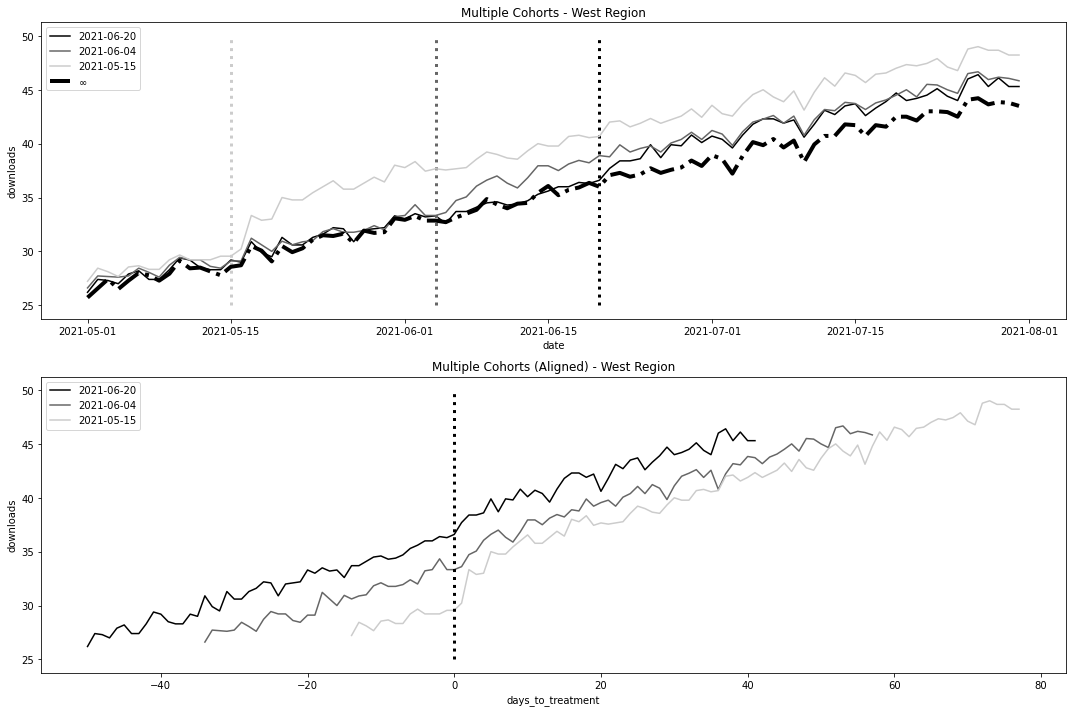

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

plt_data = (mkt_data_cohorts_w
            .groupby(["date", "cohort"])
            [["downloads"]]
            .mean()
            .reset_index()
)



for color, cohort in zip(["C0", "C1", "C2", "C3"], mkt_data_cohorts_w.query("cohort!='2100-01-01'")["cohort"].unique()):
    df_cohort = plt_data.query("cohort==@cohort")
    sns.lineplot(data=df_cohort, x="date", y="downloads",
                 label=pd.to_datetime(cohort).strftime('%Y-%m-%d'), ax=ax1)
    ax1.vlines(x=cohort, ymin=25, ymax=50, color=color, ls="dotted", lw=3)
    
    
sns.lineplot(data=plt_data.query("cohort=='2100-01-01'"), x="date", y="downloads", label="$\infty$", lw=4, ls="-.", ax=ax1)
        
ax1.legend()
ax1.set_title("Multiple Cohorts - West Region");


plt_data = (mkt_data_cohorts_w
            .assign(days_to_treatment = lambda d: (pd.to_datetime(d["date"])-pd.to_datetime(d["cohort"])).dt.days)
            .groupby(["date", "cohort"])
            [["downloads", "days_to_treatment"]]
            .mean()
            .reset_index()
)


for color, cohort in zip(["C0", "C1", "C2", "C3"], mkt_data_cohorts_w.query("cohort!='2100-01-01'")["cohort"].unique()):
    df_cohort = plt_data.query("cohort==@cohort")
    sns.lineplot(data=df_cohort, x="days_to_treatment", y="downloads",
                 label=pd.to_datetime(cohort).strftime('%Y-%m-%d'), ax=ax2)

ax2.vlines(x=0, ymin=25, ymax=50, color="black", ls="dotted", lw=3)

ax2.set_title("Multiple Cohorts (Aligned) - West Region")
ax2.legend();

plt.tight_layout()

In [43]:
twfe_model = smf.ols(
    "downloads ~ treated:post + C(date) + C(city)",
    data=mkt_data_cohorts_w
).fit()

true_tau = mkt_data_cohorts_w.query("post==1&treated==1")["tau"].mean()

print("True Effect: ", true_tau)
print("Estimated ATT:", twfe_model.params["treated:post"])

True Effect:  2.2625252108176266
Estimated ATT: 1.7599504780633743


Text(0.5, 1.0, 'Late vs Early')

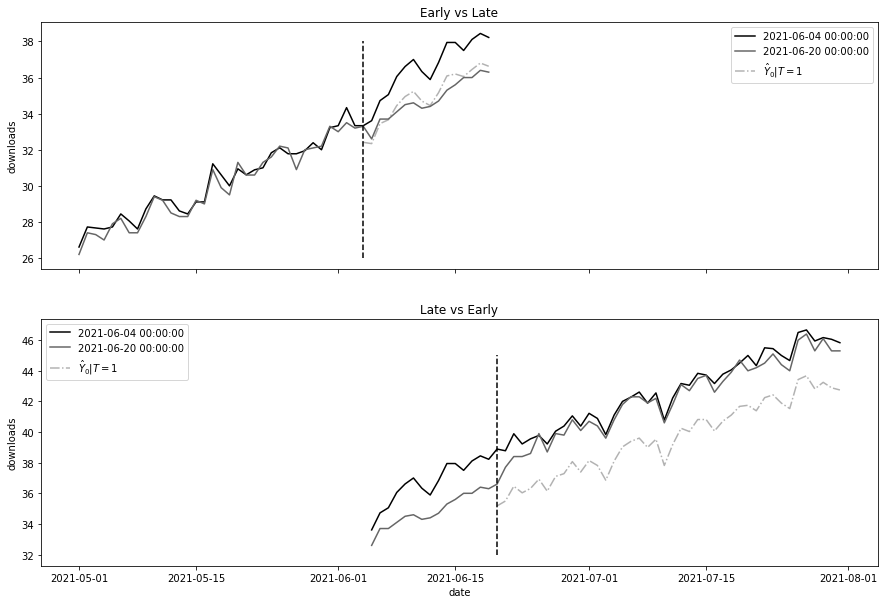

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

cohort_erly='2021-06-04'
cohort_late='2021-06-20'

## Early vs Late
did_df = (mkt_data_cohorts_w
            .loc[lambda d: d["date"].astype(str) < cohort_late]
            .query(f"cohort=='{cohort_late}' | cohort=='{cohort_erly}'")
            .assign(treated = lambda d: (d["cohort"] == cohort_erly)*1,
                    post = lambda d: (d["date"].astype(str) >= cohort_erly)*1))

m = smf.ols(
    "downloads ~ treated:post + C(date) + C(city)",
    data=did_df
).fit()


# print("Estimated", m.params["treated:post"])
# print("True", did_df.query("post==1 & treated==1")["tau"].mean())

plt_data = (did_df
            .assign(installs_hat_0 = lambda d: m.predict(d.assign(treated=0)))
            .groupby(["date", "cohort"])
            [["downloads", "post", "treated", "installs_hat_0"]]
            .mean()
            .reset_index())


sns.lineplot(data=plt_data, x="date", y="downloads", hue="cohort", ax=ax1)
sns.lineplot(data=plt_data.query("treated==1 & post==1"),
             x="date", y="installs_hat_0", ax=ax1, ls="-.", alpha=0.5, label="$\hat{Y}_0|T=1$")


ax1.vlines(pd.to_datetime(cohort_erly), 26, 38, ls="dashed")
ax1.legend()
ax1.set_title("Early vs Late")


# ## Late vs Early

did_df = (mkt_data_cohorts_w
            .loc[lambda d: d["date"].astype(str) > cohort_erly]
            .query(f"cohort=='{cohort_late}' | cohort=='{cohort_erly}'")
            .assign(treated = lambda d: (d["cohort"] == cohort_late)*1,
                    post = lambda d: (d["date"].astype(str) >= cohort_late)*1))

m = smf.ols(
    "downloads ~ treated*post + C(date) + C(city)",
    data=did_df
).fit()

# print("Estimated", m.params["treated:post"])
# print("True", did_df.query("post==1 & treated==1")["tau"].mean())


plt_data = (did_df
            .assign(installs_hat_0 = lambda d: m.predict(d.assign(treated=0)))
            .groupby(["date", "cohort"])
            [["downloads", "post", "treated", "installs_hat_0"]]
            .mean()
            .reset_index())


sns.lineplot(data=plt_data, x="date", y="downloads", hue="cohort", ax=ax2)
sns.lineplot(data=plt_data.query("treated==1 & post==1"),
             x="date", y="installs_hat_0", ax=ax2, ls="-.", alpha=0.5, label="$\hat{Y}_0|T=1$")

ax2.vlines(pd.to_datetime("2021-06-20"), 32, 45, ls="dashed")
ax2.legend()
ax2.set_title("Late vs Early")

### Heterogeneous Effect over Time


In [45]:
formula = "downloads ~ treated:post:C(cohort):C(date) + C(city)+C(date)"

twfe_model = smf.ols(formula, data=mkt_data_cohorts_w).fit()

In [46]:
df_pred = (
    mkt_data_cohorts_w
    .query("post==1 & treated==1")
    .assign(y_hat_0=lambda d: twfe_model.predict(d.assign(treated=0)))
    .assign(effect_hat=lambda d: d["downloads"] - d["y_hat_0"])
)

print("Number of param.:", len(twfe_model.params))
print("True Effect: ", df_pred["tau"].mean())
print("Pred. Effect: ", df_pred["effect_hat"].mean())

Number of param.: 510
True Effect:  2.2625252108176266
Pred. Effect:  2.259766144685074


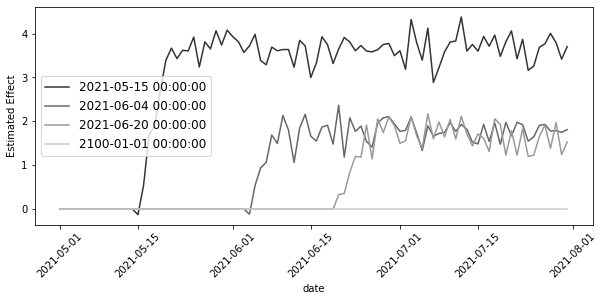

In [47]:
formula = "downloads ~ treated:post:C(cohort):C(date) + C(city) + C(date)"

twfe_model = smf.ols(formula, data=mkt_data_cohorts_w.astype({"date":str, "cohort": str})).fit()

effects = (twfe_model.params[twfe_model.params.index.str.contains("treated")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:'))
           .assign(date=lambda d: d["index"].str.extract(r':C\(date\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date"]), cohort=lambda d: pd.to_datetime(d["cohort"])))

plt.figure(figsize=(10,4))
sns.lineplot(data=effects, x="date", y="param", hue="cohort", palette="gray")
plt.xticks(rotation=45)
plt.ylabel("Estimated Effect")
plt.legend(fontsize=12)


In [48]:
cohorts = sorted(mkt_data_cohorts_w["cohort"].unique())

treated_G = cohorts[:-1]
nvr_treated = cohorts[-1]

def did_g_vs_nvr_treated(df: pd.DataFrame,
                         cohort: str,
                         nvr_treated: str,
                         cohort_col: str = "cohort",
                         date_col: str = "date",
                         y_col: str = "downloads"):
    did_g = (
        df
        .loc[lambda d:(d[cohort_col] == cohort)|
                      (d[cohort_col] == nvr_treated)]
        .assign(treated = lambda d: (d[cohort_col] == cohort)*1)
        .assign(post = lambda d:(pd.to_datetime(d[date_col])>=cohort)*1)
    )
    
    att_g = smf.ols(f"{y_col} ~ treated*post",
                    data=did_g).fit().params["treated:post"]
    size = len(did_g.query("treated==1 & post==1"))
    return {"att_g": att_g, "size": size}


atts = pd.DataFrame(
    [did_g_vs_nvr_treated(mkt_data_cohorts_w, cohort, nvr_treated)
     for cohort in treated_G]
)
    
atts

,att_g,size
0,3.455535,702
1,1.659068,1044
2,1.573687,420


In [49]:
(atts["att_g"]*atts["size"]).sum()/atts["size"].sum()

2.2247467740558697

### Covariates


In [50]:
formula = """
downloads ~ treated:post:C(cohort):C(date)
+ C(date):C(region) + C(city) + C(date)"""

twfe_model = smf.ols(formula, data=mkt_data_cohorts).fit()

In [51]:
df_pred = (
    mkt_data_cohorts
    .query("post==1 & treated==1")
    .assign(y_hat_0=lambda d: twfe_model.predict(d.assign(treated=0)))
    .assign(effect_hat=lambda d: d["downloads"] - d["y_hat_0"])
)

print("Number of param.:", len(twfe_model.params))
print("True Effect: ",  df_pred["tau"].mean())
print("Pred. Effect: ", df_pred["effect_hat"].mean())

Number of param.: 935
True Effect:  2.078397729895905
Pred. Effect:  2.0426262863584568


## Key Ideas
